# Wasserstein Barycenters

The goal of today's practical session is to compute a __Wasserstein Barycenter__ between several images, seen as measures over the plane. Given $N$ images $\mu_1, \ldots, \mu_N$ and weights $\lambda_1, \ldots, \lambda_N > 0$, we wish to find a barycenter $\bar\mu$ that solves:
$$ \min_\mu \sum_{i=1}^N \lambda_i W_2^2\left( \mu, \mu_i \right). $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot

In [3]:
# Increase this parameter to downscale the images, i.e. do it if you the algorithms are too slow on your computer
pad = 6

# Load the images:
I1 = 1 - plt.imread('images/redcross.png')[::pad, ::pad, 2]
I2 = 1 - plt.imread('images/heart.png')[::pad, ::pad, 2]
I3 = 1 - plt.imread('images/duck.png')[::pad, ::pad, 2]
I4 = 1 - plt.imread('images/tooth.png')[::pad, ::pad, 2]

We will consider the four images given below, and compute their Wasserstein barycenter for several weights.

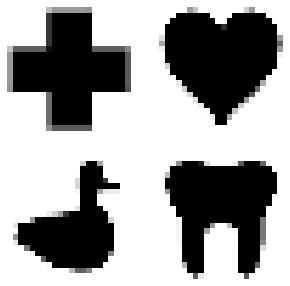

In [5]:
plt.figure(figsize=(5,5))
plt.set_cmap('Greys')

plt.subplot(2, 2, 1)
plt.imshow(I1)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(I2)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(I3)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(I4)
plt.axis('off')

plt.show()

In [6]:
# Normalize the images, to make them measures over the grid
I1 = I1 / I1.sum()
I2 = I2 / I2.sum()
I3 = I3 / I3.sum()
I4 = I4 / I4.sum()

In [7]:
# Compute the cost matrix
lw = I1.shape[0]
C = np.zeros((lw,lw,lw,lw))
for i in range(lw):
    for j in range(lw):
        for k in range(lw):
            for l in range(lw):
                C[i,j,k,l] = (i-k)**2 + (j-l)**2
C = C.reshape((lw*lw,lw*lw))
C = C / C.max()

In [8]:
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex."""
    # Adrien Gaidon - INRIA - 2011
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [9]:
# Implement sinkhorn algorithm
def sinkhorn(a, b, C, reg, warm_u, nb_iters=100):
    '''
        Return the potential u, given probability weights a,b, a cost matrix C, a regularization strength reg.
        Add a warm start for u.
    '''
    if warm_u is None:
        u = np.ones(a.shape[0])
    else:
        u = warm_u
    K = np.exp(-C/reg)
    for t in range(nb_iters):
        v = b / K.dot(u)
        u = a / K.T.dot(v)
    return u

In [10]:
def barycenter(images, weights, reg=0.0005, lr=0.003, nb_iters=100, nb_iters_sinkhorn=50, verbose=False):
    '''Return the (entropy-regularized) Wasserstein Barycenter of the input images.'''
    
    # Checking the arguments
    tol = 1e-9
    assert len(images) > 0
    assert len(images) == len(weights)
    assert reg > 0
    assert np.abs(np.sum(weights)-1.) < tol
    assert weights.min() >= 0
    
    images = np.array(images)
    weights = np.array(weights)
    
    size = images[0].shape
    n = size[0]*size[1]
    N = len(images)

    # Initialization with the Euclidean mean
    bar = weights.dot(images.reshape(N,-1)).reshape(size)
    bar = bar / bar.sum()

    # Iterations
    us = np.ones((N,n))
    for t in range(nb_iters):

        # For each image, run Sinkhorn between actual barycenter and the image
        grad = np.zeros(n)
        for i in range(N):
            u = sinkhorn(bar.reshape(n), images[i].reshape(n), C, reg=reg, warm_u = us[i], nb_iters=nb_iters_sinkhorn)
            u[u<tol] = tol
            us[i] = u
            grad = grad + weights[i]*reg*np.log(u)
        
        # Rescale the gradient
        grad = (grad - grad.min())/(grad.max() - grad.min())
        grad = grad.reshape(size)

        # Take a Projected Gradient Descent step
        bar = bar - lr*grad
        bar = euclidean_proj_simplex(bar.reshape(n,)).reshape(size)
        
        if verbose:
            plt.imshow(bar)
            plt.show()
    
    return bar

Let us compare the Euclidean mean and the Wasserstein Barycenter:

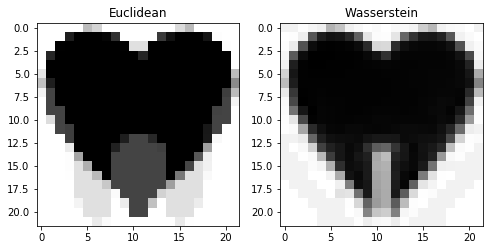

In [11]:
images = np.array([I1, I2, I3, I4])
weights = np.array([0.0, 0.8, 0., 0.2])

size = images[0].shape
N = len(images)
mean = weights.dot(images.reshape(N,-1)).reshape(size)

bar = barycenter(images, weights, reg=0.0005, lr=0.003, nb_iters=100, nb_iters_sinkhorn=50)

plt.figure(figsize=(8,5))
plt.set_cmap('Greys')

plt.subplot(1, 2, 1)
plt.imshow(mean)
plt.title('Euclidean')

plt.subplot(1, 2, 2)
plt.imshow(bar)
plt.title('Wasserstein')

plt.show()

You should now interpolate between the four images, with bilinear interpolation of the weights. You should obtain something like this:
![Results](images/result.png "Results")

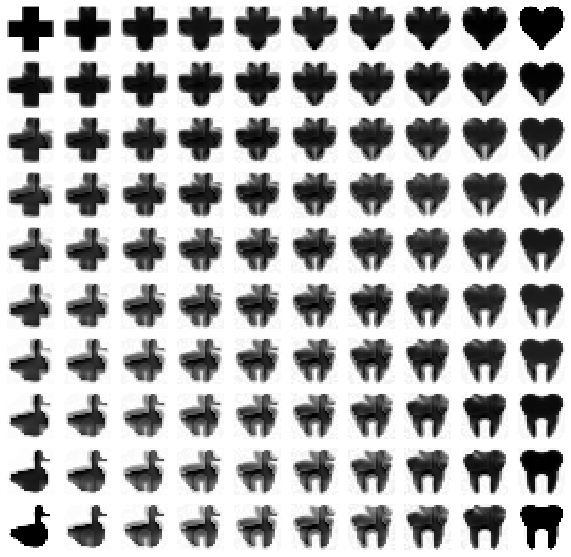

In [12]:
nb_images = 10 # The total number of images will be the squared of this. Decrease this nulmber if you are having computational issues
images = np.array([I1, I3, I2, I4])

B = np.zeros((nb_images,nb_images,size[0],size[1]))

plt.figure(figsize=(10,10))
for i in range(nb_images):
    for j in range(nb_images):
        plt.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * np.array([1,0,0,0]) + tx * np.array([0,1,0,0])
        tmp2 = (1 - tx) * np.array([0,0,1,0]) + tx * np.array([0,0,0,1])
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            plt.imshow(I1)
            plt.axis('off')
        elif i == 0 and j == (nb_images - 1):
            plt.imshow(I2)
            plt.axis('off')
        elif i == (nb_images - 1) and j == 0:
            plt.imshow(I3)
            plt.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            plt.imshow(I4)
            plt.axis('off')
        else:
            # call to barycenter computation
            B[i,j] = barycenter(images, weights, reg=0.0005, lr=0.001, nb_iters=150, nb_iters_sinkhorn=50)
            plt.imshow(B[i,j])
            plt.axis('off')
plt.show()